In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [3]:
cali = fetch_california_housing()
cali_df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
cali_df['Target'] = cali['target']
cali_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
data = torch.from_numpy(cali_df.values).float()
data.shape

torch.Size([20640, 9])

In [5]:
X = data[:, :-1]
y = data[:, -1:]
scaler = StandardScaler().fit(X)
X_sc = torch.from_numpy(scaler.transform(X).round(4)).float()
X_sc.shape[-1], y.shape[-1]

(8, 1)

In [7]:
n_epochs = 10000
batch_size = 256
lr = 1e-2
print_interval = 1000

In [8]:
model = nn.Sequential(
    nn.Linear(X_sc.shape[-1], 5),
    nn.LeakyReLU(0.01),
    nn.Linear(5, 3),
    nn.LeakyReLU(0.01),
    nn.Linear(3, y.shape[-1])
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=1, bias=True)
)


In [9]:
opt = optim.Adam(model.parameters(), lr=lr)

In [18]:
for i in range(n_epochs):
    indices = torch.randperm(X_sc.size(0))
    x_ = torch.index_select(X_sc, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += float(loss)
        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)

    if (i+1) % print_interval == 0:
        print(f'Epoch {i+1}: Loss={total_loss:.4f}')

y_hat = torch.concat(y_hat, dim=0)
y = torch.concat(y_, dim=0)

Epoch 1000: Loss=0.3136
Epoch 2000: Loss=0.3141
Epoch 3000: Loss=0.3122
Epoch 4000: Loss=0.3121
Epoch 5000: Loss=0.3118
Epoch 6000: Loss=0.3118
Epoch 7000: Loss=0.3126
Epoch 8000: Loss=0.3150
Epoch 9000: Loss=0.3127
Epoch 10000: Loss=0.3156


In [19]:
result_df = pd.DataFrame(torch.concat([y, y_hat], dim=1).detach_().numpy(), columns=['y', 'y_hat']).clip(lower=0, upper=5)
result_df

,y,y_hat
0,1.196,1.176889
1,2.464,2.383476
2,1.308,1.483413
3,0.750,0.905503
4,4.130,3.963245
...,...,...
20635,1.468,1.599388
20636,0.982,0.835792
20637,1.673,1.489821
20638,0.616,0.762349


c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

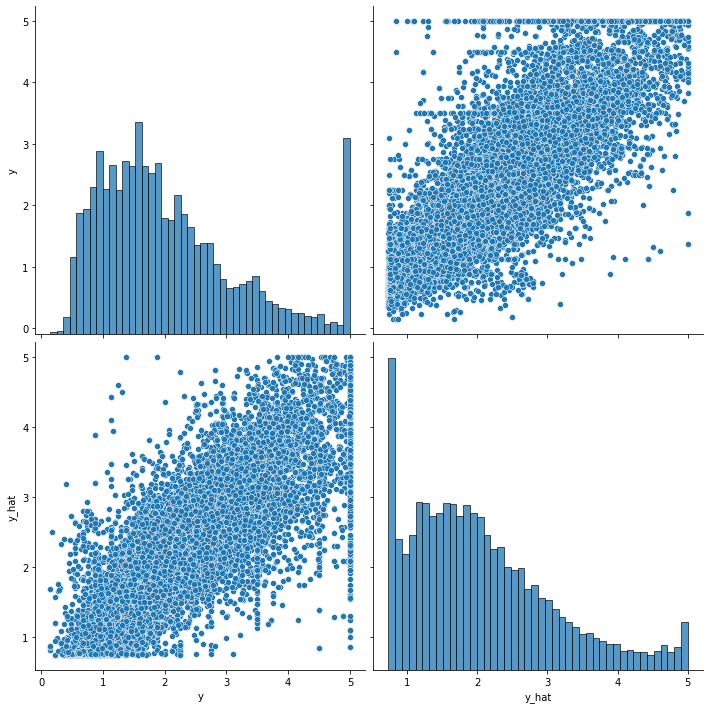

In [20]:
sns.pairplot(result_df, height=5)
plt.show()